# 의사결정나무

In [22]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# export_graphviz: 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz

# 다른 방식(.dot -> .png 형식, 출력화면에 맞는)으로 Tree 출력
from subprocess import call
from IPython.display import Image

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# scaling
from sklearn.preprocessing import StandardScaler

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

import pydotplus
from IPython.display import Image

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df_raw = pd.read_csv("/content/drive/MyDrive/PABA/data_file/final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [7]:
df_raw['fur_no'] = df_raw['fur_no'].astype(str)
df_raw['fur_input_row'] = df_raw['fur_input_row'].astype(str)

In [8]:
df_raw['fur_input_row'].unique()

array(['1', '2'], dtype=object)

In [9]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method', 'fur_input_row']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [10]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
0,32,3700,15100,1144,116,1133,59,259,934,8,...,1,0,0,1,0,0,1,1,1,0
1,32,3700,15100,1144,122,1135,53,238,937,8,...,0,1,0,1,0,0,1,1,1,1
2,33,3600,19200,1129,116,1121,55,258,889,8,...,1,0,0,1,0,0,1,1,1,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,...,1,0,0,1,0,0,1,1,1,0
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,...,0,1,0,1,0,0,1,1,1,1
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,...,1,0,0,1,0,0,1,1,1,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method,fur_input_row
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어),1
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어),2
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어),1


In [11]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
# 원래 연속형+ Dummied 범주형 쓰는 이유:
# 1. 데이터의 자연스러운 분포 유지(스케일링의 경우, 자연스러운 분포로 변형되어 분할지점을 찾는데 방해 될 수 있음)
# 2. 범주형 변수의 처리(결정 트리가 각 범주를 명확하게 구분할 수 있게 해줌)
# 3. 스케일링의 불필요성(모델이 변수의 절대값보다는 변수의 분할 지점을 통해 데이터를 구분하기 때문)
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3,stratify = df_x_raw_dummy["steel_kind_T"],random_state=2024)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# # 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
# df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=1010)

# display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# # 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
# df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=1010)

# display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
565,81,2900,9800,1139,132,1124,80,287,877,6,...,0,1,1,0,0,0,1,1,0,1
771,26,2600,31300,1165,73,1160,63,223,1026,8,...,1,0,1,0,0,0,0,0,0,0
46,51,3100,12400,1133,57,1125,103,238,862,6,...,1,0,0,1,0,0,1,1,1,0
703,19,2700,54300,1178,69,1165,57,227,1005,10,...,1,0,0,1,0,0,0,1,0,0
457,14,2900,54300,1166,72,1163,60,221,923,10,...,1,0,0,0,1,0,0,1,0,0


In [12]:
df_train_x_rd

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
565,81,2900,9800,1139,132,1124,80,287,877,6,...,0,1,1,0,0,0,1,1,0,1
771,26,2600,31300,1165,73,1160,63,223,1026,8,...,1,0,1,0,0,0,0,0,0,0
46,51,3100,12400,1133,57,1125,103,238,862,6,...,1,0,0,1,0,0,1,1,1,0
703,19,2700,54300,1178,69,1165,57,227,1005,10,...,1,0,0,1,0,0,0,1,0,0
457,14,2900,54300,1166,72,1163,60,221,923,10,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,14,2800,54400,1168,72,1161,60,187,941,10,...,0,1,0,1,0,0,0,0,0,1
463,18,3100,46300,1194,73,1170,61,213,982,9,...,1,0,0,1,0,0,0,1,0,0
883,20,2900,49400,1177,72,1166,60,237,998,10,...,0,1,0,1,0,0,0,1,0,1
18,34,2200,30500,1119,126,1119,72,263,931,8,...,1,0,1,0,0,0,1,1,0,0


In [13]:
df_train_y

565    0
771    1
46     0
703    1
457    0
      ..
745    0
463    1
883    0
18     0
706    0
Name: scale, Length: 662, dtype: int64

In [14]:
tree_uncust = DecisionTreeClassifier()
tree_uncust.fit(df_train_x_rd, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_rd, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.989


In [15]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경.
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [16]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.923,0.909
1,2,0.962,0.947
2,3,0.968,0.954
3,4,0.968,0.954
4,5,0.991,0.986
5,6,0.991,0.986
6,7,0.994,0.986
7,8,1.000,0.989
8,9,1.000,0.989
9,10,1.000,0.989


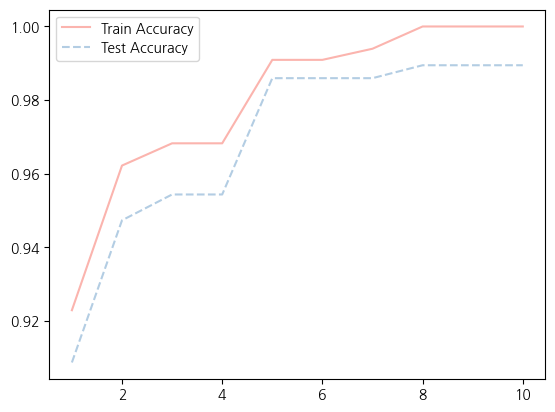

In [17]:
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

max depth = 7

In [18]:
v_feature_name = df_train_x_rd.columns

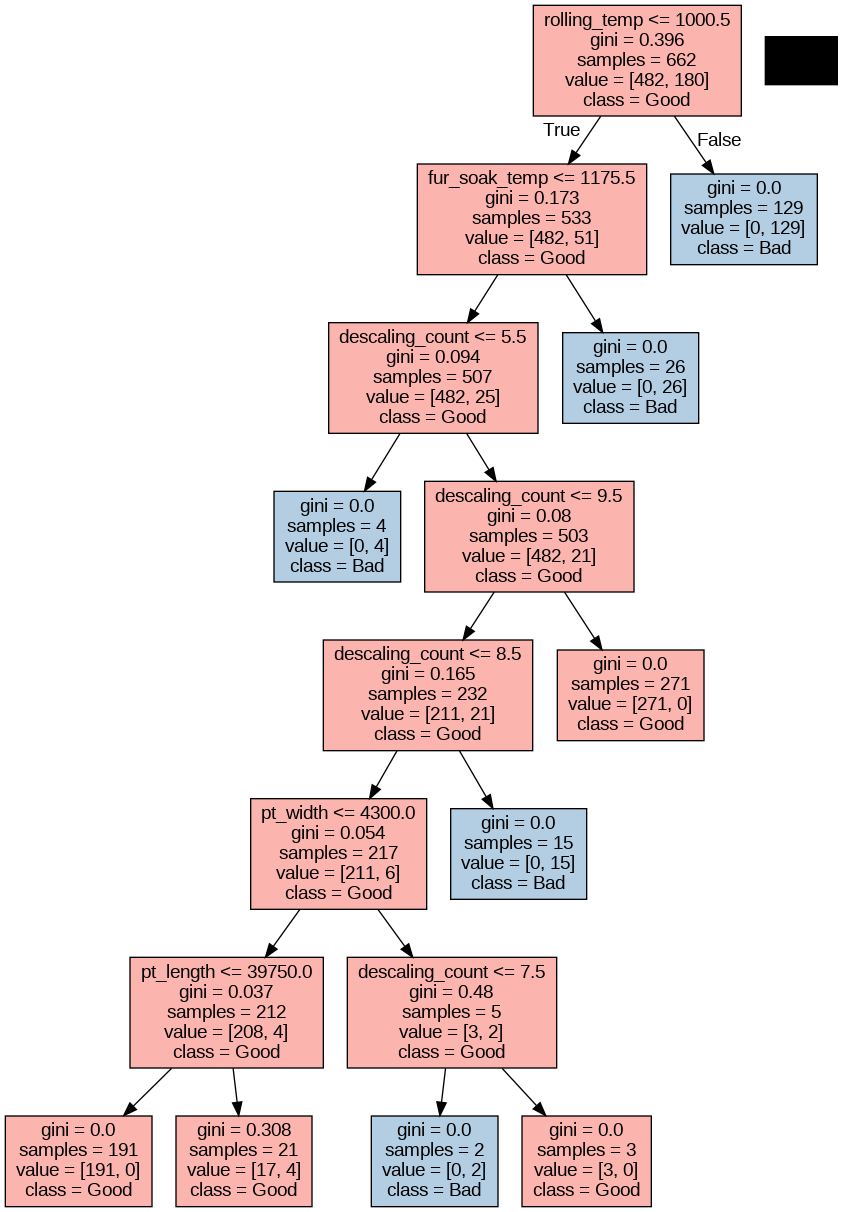

In [24]:
tree_low = DecisionTreeClassifier(max_depth = 7)
tree_low.fit(df_train_x_rd, df_train_y)

# 'Pastel1' 팔레트의 RGB 색상 코드를 16진수 형태로 변환
hex_colors = colors.as_hex()

# 트리 모델을 tree_low.dot 파일로 저장. (목표변수 레이블 지정(class_names):0-Good,1-Bad)
export_graphviz(tree_low, out_file="tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

# 트리 결과 시각화
with open("tree_low.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)

nodes = graph.get_node_list()
for i, node in enumerate(nodes):
    if node.get_label():
        if "Good" in node.get_label():
            # 여기서는 'Good' 레이블을 가진 노드에 첫 번째 색상을 적용
            node.set_fillcolor(hex_colors[0])
        elif "Bad" in node.get_label():
            # 'Bad' 레이블을 가진 노드에 두 번째 색상을 적용
            node.set_fillcolor(hex_colors[1])

image = Image(graph.create_png())
display(image)
# display(graphviz.Source(dot_graph))

In [42]:
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수
para_split = [n_split for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth=7)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [43]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.994,0.986
1,3,0.994,0.986
2,4,0.994,0.986
3,5,0.994,0.986
4,6,0.991,0.986
5,7,0.991,0.986
6,8,0.991,0.986
7,9,0.991,0.986
8,10,0.991,0.986
9,11,0.991,0.986


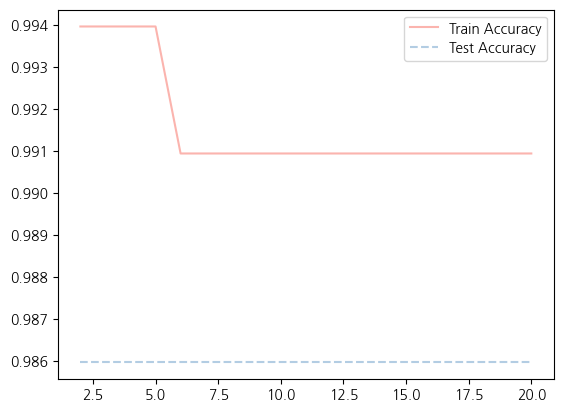

In [44]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

test 정확도가 변하지 않으므로 선택하지 않음

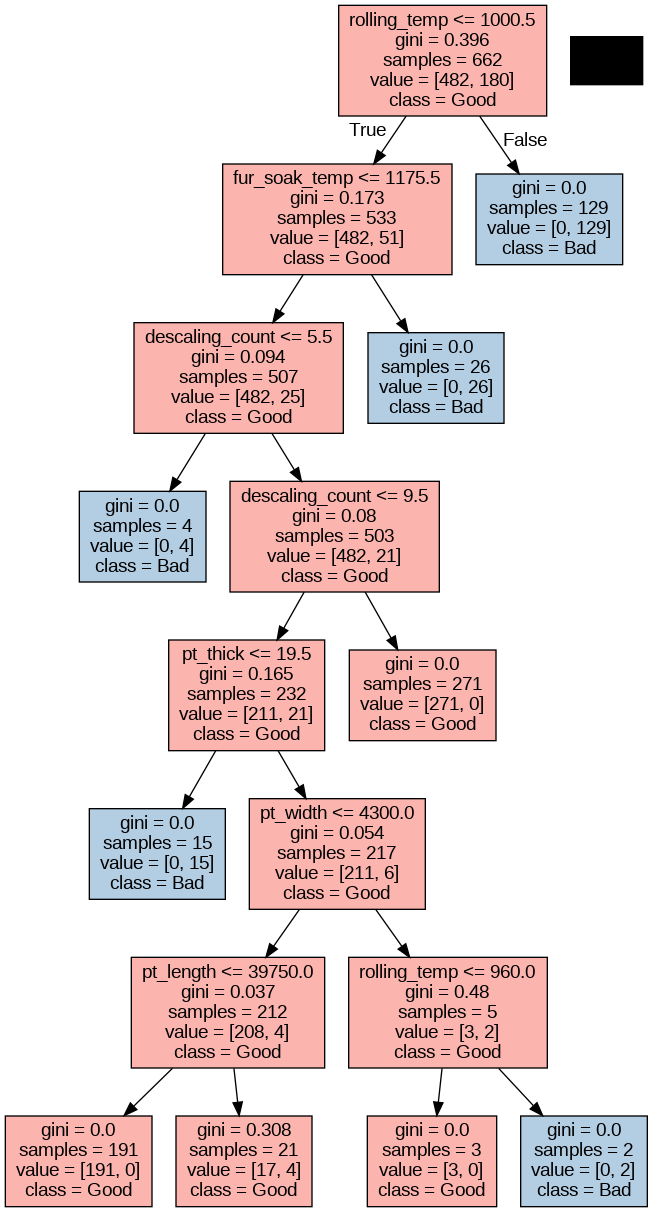

In [45]:
tree_low = DecisionTreeClassifier(max_depth=7)
tree_low.fit(df_train_x_rd, df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_low.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

with open("tree_low.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)

nodes = graph.get_node_list()
for i, node in enumerate(nodes):
    if node.get_label():
        if "Good" in node.get_label():
            # 여기서는 'Good' 레이블을 가진 노드에 첫 번째 색상을 적용
            node.set_fillcolor(hex_colors[0])
        elif "Bad" in node.get_label():
            # 'Bad' 레이블을 가진 노드에 두 번째 색상을 적용
            node.set_fillcolor(hex_colors[1])

image = Image(graph.create_png())
display(image)

In [46]:
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수.
para_leaf = [n_leaf for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, \
		max_depth=5)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [47]:
# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.991,0.986
1,2,0.991,0.986
2,3,0.991,0.986
3,4,0.991,0.986
4,5,0.985,0.979
5,6,0.985,0.979
6,7,0.985,0.979
7,8,0.985,0.979
8,9,0.985,0.979
9,10,0.985,0.979


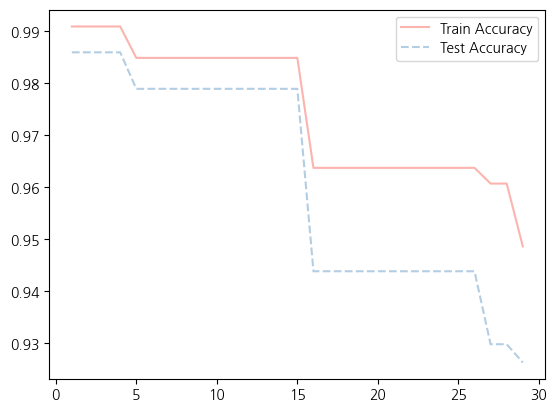

In [48]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

15로 선택

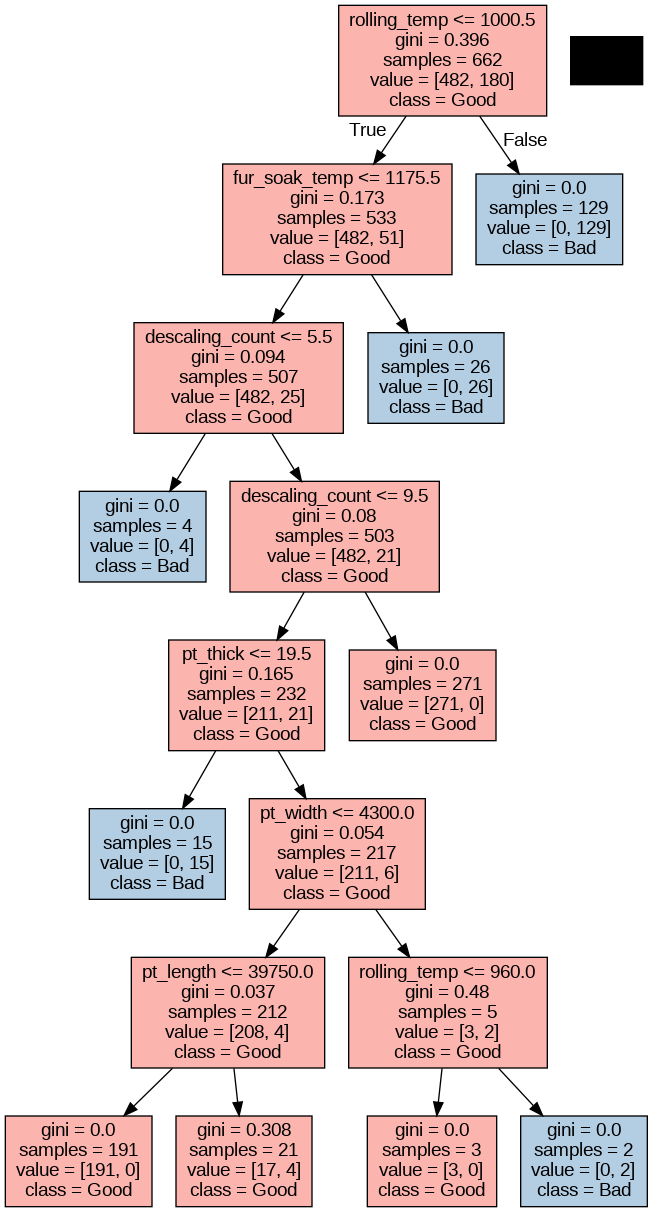

In [51]:
# 잎사귀의 최소 자료 수가 인 모델
tree_low = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)
tree_low.fit(df_train_x_rd, df_train_y)

export_graphviz(tree_low, out_file=" tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

# with open(" tree_low.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

with open("tree_low.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)

nodes = graph.get_node_list()
for i, node in enumerate(nodes):
    if node.get_label():
        if "Good" in node.get_label():
            # 여기서는 'Good' 레이블을 가진 노드에 첫 번째 색상을 적용
            node.set_fillcolor(hex_colors[0])
        elif "Bad" in node.get_label():
            # 'Bad' 레이블을 가진 노드에 두 번째 색상을 적용
            node.set_fillcolor(hex_colors[1])

image = Image(graph.create_png())
display(image)

In [35]:
tree_final = DecisionTreeClassifier(max_depth=7, min_samples_split = 15)
tree_final.fit(df_train_x_rd, df_train_y)

DecisionTreeClassifier(max_depth=7, min_samples_split=15)

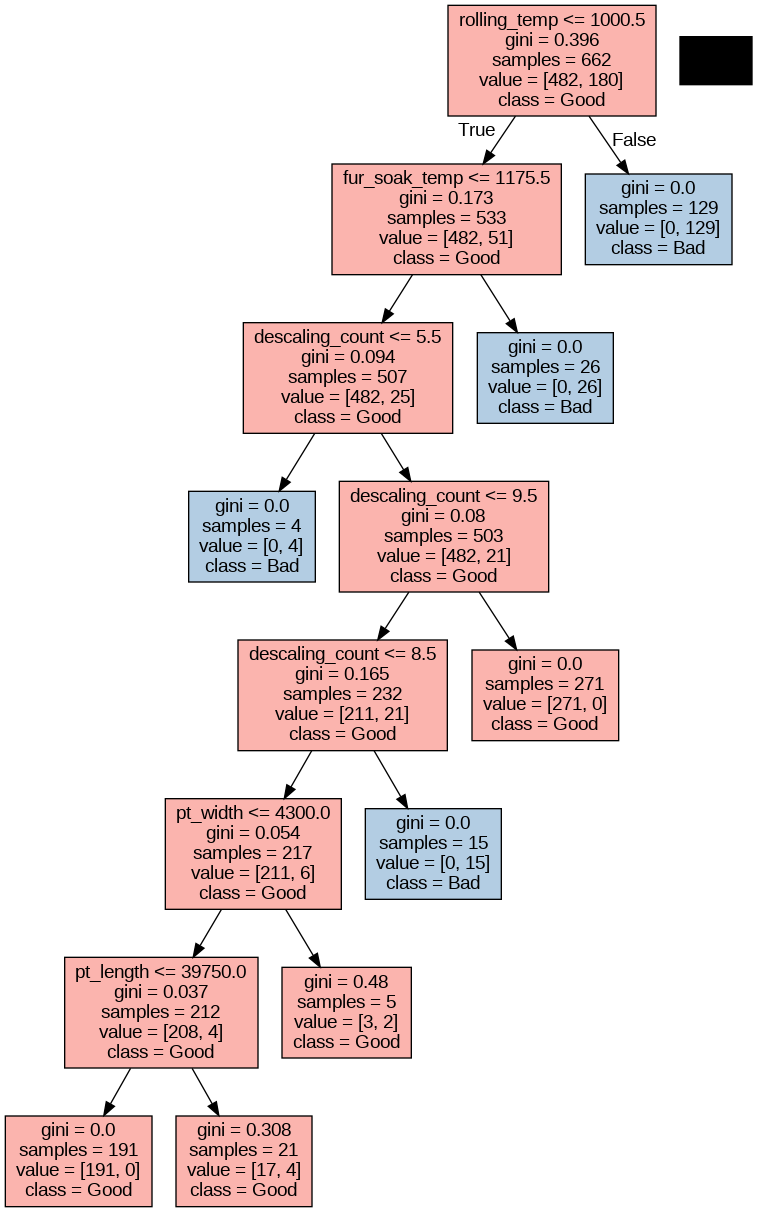

In [52]:
# tree_final.dot으로 결과 저장
export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_final.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

with open("tree_final.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)

nodes = graph.get_node_list()
for i, node in enumerate(nodes):
    if node.get_label():
        if "Good" in node.get_label():
            # 여기서는 'Good' 레이블을 가진 노드에 첫 번째 색상을 적용
            node.set_fillcolor(hex_colors[0])
        elif "Bad" in node.get_label():
            # 'Bad' 레이블을 가진 노드에 두 번째 색상을 적용
            node.set_fillcolor(hex_colors[1])

image = Image(graph.create_png())
display(image)

In [37]:
# 평가
y_pred = tree_final.predict(df_test_x_rd)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_rd, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.986

Test Confusion matrix: 
[[202   0]
 [  4  79]]
              precision    recall  f1-score   support

           0      0.981     1.000     0.990       202
           1      1.000     0.952     0.975        83

    accuracy                          0.986       285
   macro avg      0.990     0.976     0.983       285
weighted avg      0.986     0.986     0.986       285



In [38]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.671
5,fur_soak_temp,0.177
9,descaling_count,0.142
1,pt_width,0.006
2,pt_length,0.005
24,purpose_용접구조용,0.000
20,fur_input_row_1,0.000
21,fur_input_row_2,0.000
22,purpose_OTHERS,0.000
23,purpose_선체구조용(조선용),0.000


In [67]:
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

Text(0, 0.5, '설명변수')

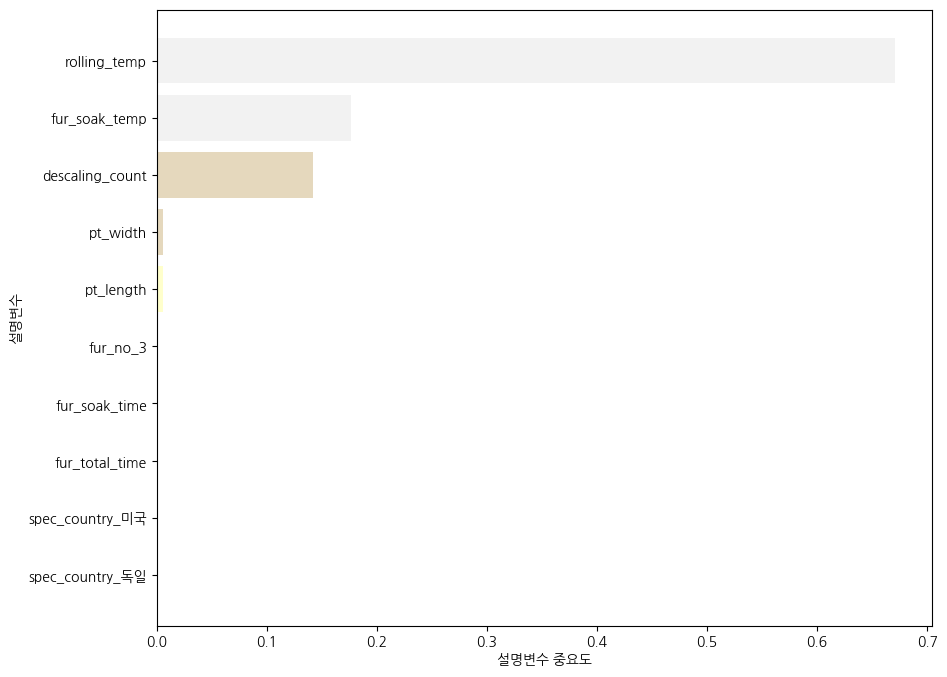

In [83]:
import matplotlib.cm as cm
# sort_values : 중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("Importance", ascending=True, inplace = True)
top10_df_importance = df_importance.tail(10)
coordinates = range(len(top10_df_importance))

plt.figure(figsize=(10,8))

color_palette = cm.get_cmap('Pastel1', 10) # 'tab10' 팔레트 사용, 10개 색상
colors = color_palette(np.arange(10))

plt.barh(y = coordinates, width = top10_df_importance["Importance"], color=colors)
plt.yticks(coordinates, top10_df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

Text(0, 0.5, '설명변수')

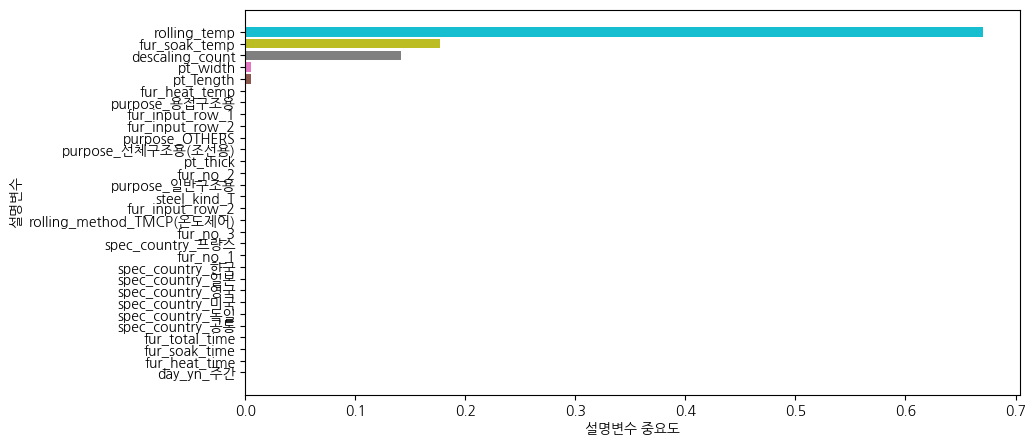

In [76]:

# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = df_importance["Importance"], color=colors)
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [40]:
estimator = DecisionTreeClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth, "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}
# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_dt.fit(df_train_x_rd, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))


best estimator model: 
DecisionTreeClassifier(max_depth=10)

best parameter: 
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

best score: 
0.983
